In [2]:
#Import modules
%matplotlib inline

#handling data
import pandas as pd
import numpy as np
from scipy import stats
from operator import itemgetter

#handling information
import re
import json

#handling plots
import matplotlib.pyplot as plt
import seaborn as sns

#for network creation
import networkx as nx

## Read csv to DataFrame

In [3]:
pd.set_option('display.float_format', lambda x: '%.f' % x)

In [4]:
# Read json into a pandas dataframe
tweets_df = pd.read_csv("data/processed/tweets_08010807_notverified.csv")

/Users/yuikondo/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,8,9,12,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# Let's check the name of the columns
tweets_df.columns
tweets_df.shape[0]

19834

In [6]:
# dataを書き換える
tweets_df['id'] = tweets_df['tweet_id']
tweets_df['in_reply_to_screen_name'] = tweets_df['in_reply_to_username']
tweets_df['in_reply_to_status_id'] = tweets_df[tweets_df["referenced_tweet_type"] == 'replied_to']['referenced_tweet_id']
tweets_df['retweeted_id'] = tweets_df[tweets_df["referenced_tweet_type"] == 'retweeted']['referenced_user_id']
tweets_df['retweeted_screen_name'] = tweets_df[tweets_df["referenced_tweet_type"] == 'retweeted']['referenced_username']
tweets_df['screen_name'] = tweets_df['username']
tweets_df['followers_count'] = tweets_df['user_followers']


In [7]:
tweets_final = tweets_df[["created_at", "id", "in_reply_to_screen_name", "in_reply_to_status_id", "in_reply_to_user_id",
           "retweeted_id", "retweeted_screen_name", "text", "user_id", "screen_name", "followers_count"]]

In [8]:
tweets_data_20220801 = tweets_final[(tweets_final['created_at'] >= '2022-08-01') & (tweets_final['created_at'] < '2022-08-02')]
tweets_data_20220801.shape[0]

3343

In [11]:
centrality = tweets_data_20220801[(tweets_data_20220801['user_id'] == '2924898150')]


In [12]:
centrality

,created_at,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,retweeted_id,retweeted_screen_name,text,user_id,screen_name,followers_count


In [43]:
tweets_data_200220801.shape[0]

NameError: name 'tweets_data_200220801' is not defined

とりあえずメンションはなし

In [7]:
# Get the user mentions 
# とりあえずメンションはなし。
# def get_usermentions(tweets_final):
#     # Inside the tag 'entities' will find 'user mentions' and will get 'screen name' and 'id'
#     tweets_final["user_mentions_screen_name"] = tweets_df["entities"].apply(lambda x: x["user_mentions"][0]["screen_name"] if x["user_mentions"] else np.nan)
#     tweets_final["user_mentions_id"] = tweets_df["entities"].apply(lambda x: x["user_mentions"][0]["id_str"] if x["user_mentions"] else np.nan)
#     return tweets_final

# Interactions

In [11]:
# Get the interactions between the different users
def get_interactions(row):
    # From every row of the original dataframe
    # First we obtain the 'user_id' and 'screen_name'
    user = row["user_id"], row["screen_name"]
    # Be careful if there is no user id
    if user[0] is None:
        return (None, None), []
    
    # The interactions are going to be a set of tuples
    interactions = set()
    
    # Add all interactions 
    # First, we add the interactions corresponding to replies adding the id and screen_name
    interactions.add((row["in_reply_to_user_id"], row["in_reply_to_screen_name"]))
    # After that, we add the interactions with retweets
    interactions.add((row["retweeted_id"], row["retweeted_screen_name"]))
#     # And later, the interactions with user mentions
#     interactions.add((row["user_mentions_id"], row["user_mentions_screen_name"]))
    
    # Discard if user id is in interactions
    interactions.discard((row["user_id"], row["screen_name"]))
    # Discard all not existing values
    interactions.discard((None, None))
    # Return user and interactions
    return user, interactions

In [12]:
tweets_data_20220801 = tweets_data_20220801.where((pd.notnull(tweets_final)), None)

In [13]:
tweets_data_20220801.head(5)

,created_at,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,retweeted_id,retweeted_screen_name,text,user_id,screen_name,followers_count
491,2022-08-01T00:15:26.000Z,1553897156846632960,None,NaN,None,3118622494,hotaka_tsukada,RT @hotaka_tsukada: おかしいですね。党外団体・神道政治連盟の国会議員懇談...,785460695693348864,a7R2Ljtm,91
492,2022-08-01T00:15:21.000Z,1553897133153333248,None,NaN,None,760295281787232256,ChizuruA1,RT @ChizuruA1: 選択制夫婦別姓や同性婚の成立を反対する理由として、「家庭」「家...,764640015238377474,iamnot_abe1,2834
493,2022-08-01T00:15:20.000Z,1553897131802771456,None,NaN,None,2924898150,aiko33151709,RT @aiko33151709: ネット上では流布していたカルト統一教会と自民党との密接な...,874155767720321024,hiro6456_h,298
494,2022-08-01T00:15:20.000Z,1553897130351534080,None,NaN,None,1547681159500673024,jn_lyio,RT @jn_lyio: ジェンダー平等になると不幸な女性が減る→宗教に走る人が少なくなる→...,68994591,from1970,3127
495,2022-08-01T00:14:48.000Z,1553896994707361792,None,NaN,None,2924898150,aiko33151709,RT @aiko33151709: ネット上では流布していたカルト統一教会と自民党との密接な...,862753244,SunnyOceangogo,331


In [14]:
graph = nx.Graph()

In [15]:
for index, tweet in tweets_data_20220801.iterrows():
    user, interactions = get_interactions(tweet)
    user_id, user_name = user
    tweet_id = tweet["id"]
    #tweet_sent = tweet["sentiment"]
    for interaction in interactions:
        int_id, int_name = interaction
        graph.add_edge(user_id, int_id, tweet_id=tweet_id)
        

        graph.nodes[user_id]["name"] = user_name
        graph.nodes[int_id]["name"] = int_name       

In [16]:
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")

There are 3489 nodes and 3296 edges present in the Graph


In [17]:
degrees = [val for (node, val) in graph.degree()]

The degree of a node u, denoted as deg(u), is the number of edges that occur to that node. In simpler words, the number of connections a particular node has. The maximum degree of a graph and the minimum degree of a graph are the maximum and minimum degree of its nodes, respectively.

In [18]:
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")  

The maximum degree of the Graph is 497
The minimum degree of the Graph is 1


In [19]:

print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}") 

The average degree of the nodes in the Graph is 1.9
The most frequent degree of the nodes found in the Graph is 1


In [20]:
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")

The graph is not connected


In [21]:
print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")  

There are 381 connected components in the Graph


In [22]:
subgraphs = (graph.subgraph(c) for c in nx.connected_components(graph))
largest_subgraph  = max(subgraphs, key=len)
largest_subgraph

In [23]:
print(f"There are {largest_subgraph.number_of_nodes()} nodes and {largest_subgraph.number_of_edges()} \
edges present in the largest component of the Graph")

There are 2371 nodes and 2558 edges present in the largest component of the Graph


In [24]:
if nx.is_connected(largest_subgraph):
    print("The graph is connected")
else:
    print("The graph is not connected")

The graph is connected


Clustering and transitivity measure the tendency for nodes to cluster together or for edges to form triangles. In our context, they are measures of the extent to which the users interacting with one particular user tend to interact with each other as well. The difference is that transitivity weights nodes with a large degree higher.  The clustering coefficient, a measure of the number of triangles in a graph, is calculated as the number of triangles connected to node i divided by the number of sets of two edges connected to node i (Triple nodes). While the transitivity coefficient is calculated as 3 multiply by the number of triangles in the network divided by the number of connected triples of nodes in the network. These two parameters are very important when analyzing social networks because it gives us an insight into how users tend to create tightly knot groups characterized by relatively high-dense ties.

In [25]:
print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")

The average clustering coefficient is 0.0005825842611663608 in the largest subgraph
The transitivity of the largest subgraph is 7.176175098672408e-05


In [26]:
print(f"The diameter of our Graph is {nx.diameter(largest_subgraph)}")
print(f"The average distance between any two nodes is {nx.average_shortest_path_length(largest_subgraph):.2f}")

The diameter of our Graph is 19
The average distance between any two nodes is 7.22


Now, we are going to focus on network centrality which captures the importance of a node's position in the network considering: degree on the assumption that an important node will have many connections, closeness on the assumption that important nodes are close to other nodes, and finally, betweenness on the assumption that important nodes are well situated and connect other nodes. For this, we are going to use the following functions degree_centrality, closenness_centrality and betwenness_centrality, all which return a list of each node and its centrality score. We will particularly capture the node with the best score in each one.

In [28]:
graph_centrality = nx.degree_centrality(largest_subgraph)

In [29]:
max_de = max(graph_centrality.items(), key=itemgetter(1))

In [30]:
graph_closeness = nx.closeness_centrality(largest_subgraph)

In [31]:
max_clo = max(graph_closeness.items(), key=itemgetter(1))

In [32]:
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)

In [33]:
max_bet = max(graph_betweenness.items(), key=itemgetter(1))
print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

the node with id 2924898150.0 has a degree centrality of 0.21 which is the maximum of the Graph
the node with id 9.495210258630697e+17 has a closeness centrality of 0.19 which is the maximum of the Graph
the node with id 2924898150.0 has a betweenness centrality of 0.42 which is the maximum of the Graph


Now, we can get to see how the Graph looks like. For that, we will use nx.drawing.layout to apply node positioning algorithms for the graph drawing. Specifically, we will use spring_layout that uses force-directed graph drawing which purpose is to position the nodes in two-dimensional space so that all the edges are of equal length and as few crossing edges as possible. It achieves this by assigning forces among the set of edges and nodes based on their relative positions and then uses this to simulate the motion of the edges and nodes. One of the parameters that we can adjust is k, the optimal distance between nodes; as we increase the value, the nodes will farther apart. Once, that we got the positions, we are also going to create a special list so that we can draw the two nodes with higher centrality that we found in different colors to highlight them.

NetworkXError: Node '2' has no position.

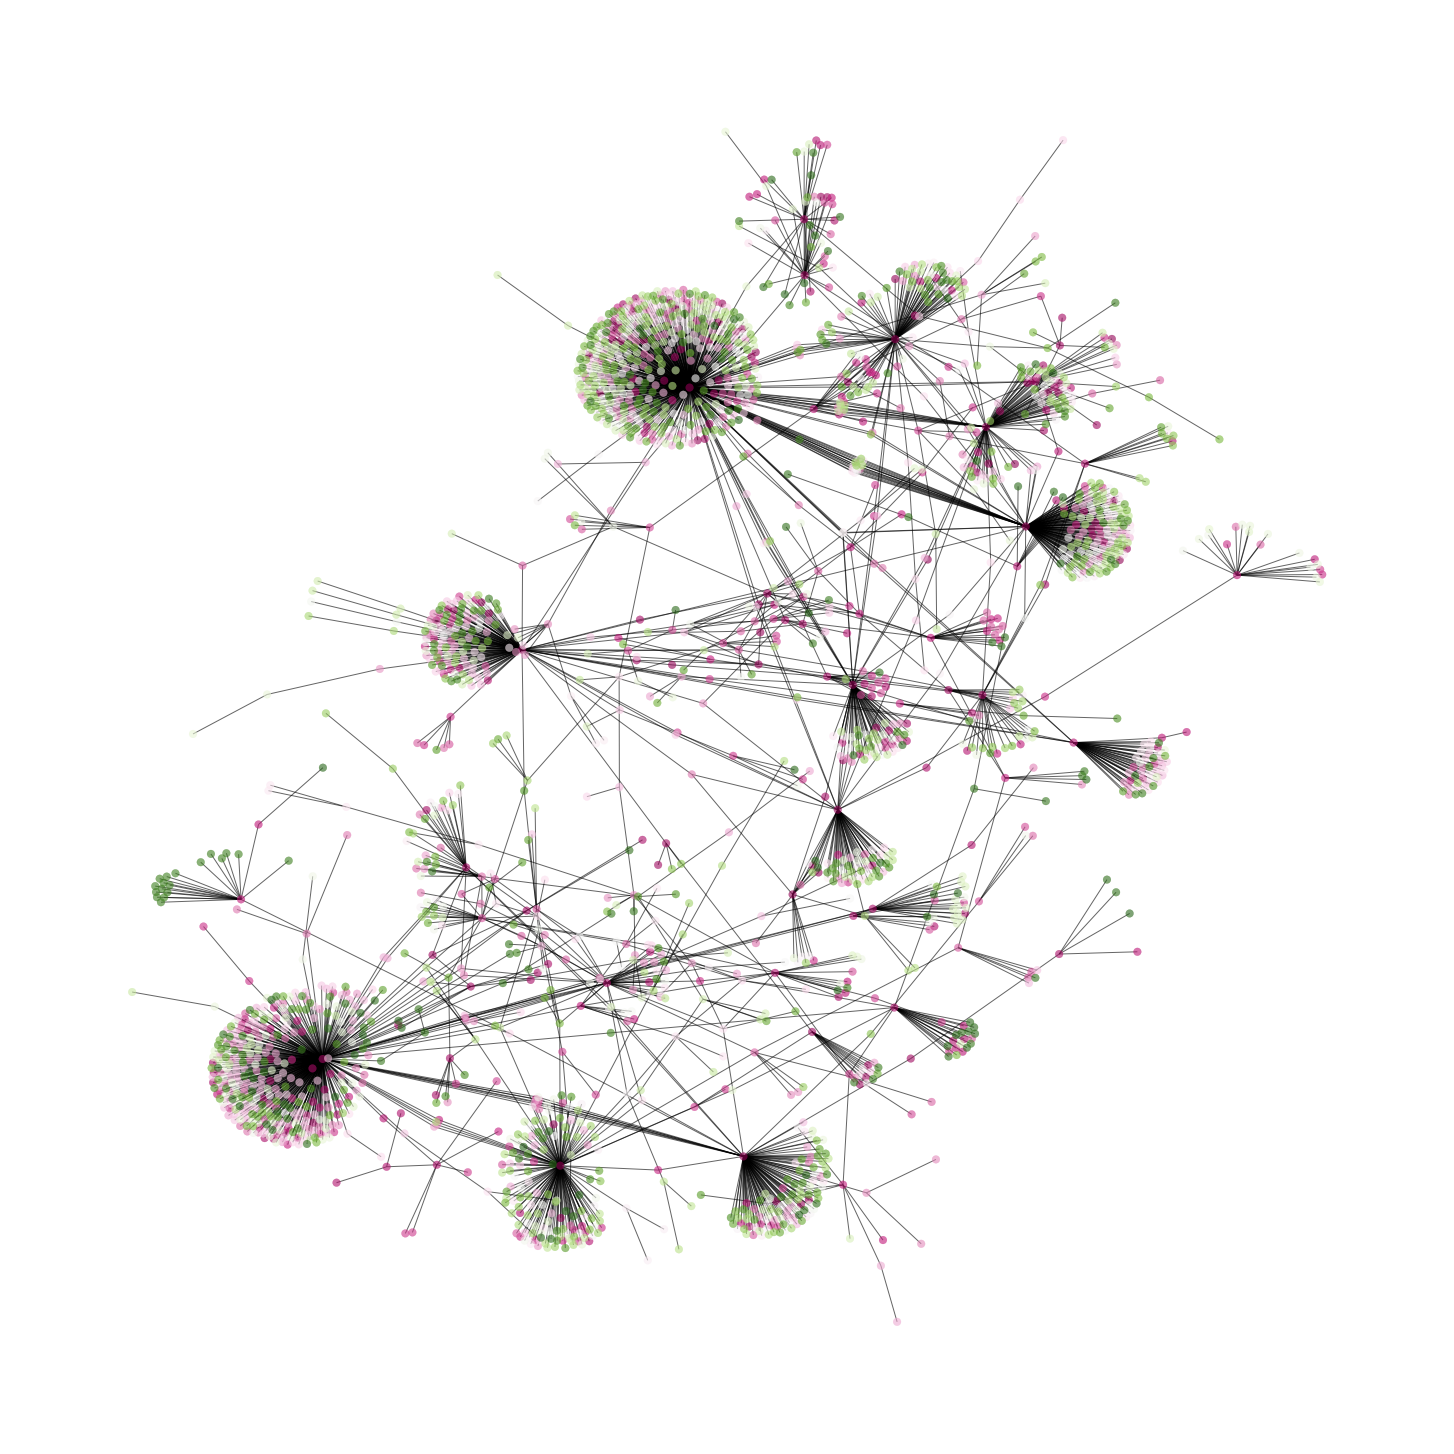

In [35]:
node_and_degree = largest_subgraph.degree()
colors_central_nodes = ['orange', 'red']
central_nodes = '2924898150'
pos = nx.spring_layout(largest_subgraph, k=0.05)
plt.figure(figsize = (20,20))
nx.draw(largest_subgraph, pos=pos, node_color=range(2371), cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=300, node_color=colors_central_nodes)
plt.savefig('graphfinal.png')
plt.show()

## Retweet

In [40]:
# Get the interactions between the different users
def get_interactions(row):
    # From every row of the original dataframe
    # First we obtain the 'user_id' and 'screen_name'
    user = row["user_id"], row["screen_name"]
    # Be careful if there is no user id
    if user[0] is None:
        return (None, None), []
    
    # The interactions are going to be a set of tuples
    interactions = set()
    
    # Add all interactions 
    # First, we add the interactions corresponding to replies adding the id and screen_name
    interactions.add((row["in_reply_to_user_id"], row["in_reply_to_screen_name"]))
    # After that, we add the interactions with retweets
    interactions.add((row["retweeted_id"], row["retweeted_screen_name"]))
#     # And later, the interactions with user mentions
#     interactions.add((row["user_mentions_id"], row["user_mentions_screen_name"]))
    
    # Discard if user id is in interactions
    interactions.discard((row["user_id"], row["screen_name"]))
    # Discard all not existing values
    interactions.discard((None, None))
    # Return user and interactions
    return user, interactions

tweets_data_20220801 = tweets_data_20220801.where((pd.notnull(tweets_final)), None)
graph = nx.Graph()
for index, tweet in tweets_data_20220801.iterrows():
    user, interactions = get_interactions(tweet)
    user_id, user_name = user
    tweet_id = tweet["id"]
    #tweet_sent = tweet["sentiment"]
    for interaction in interactions:
        int_id, int_name = interaction
        graph.add_edge(user_id, int_id, tweet_id=tweet_id)
        

        graph.nodes[user_id]["name"] = user_name
        graph.nodes[int_id]["name"] = int_name  
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")
degrees = [val for (node, val) in graph.degree()]
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")  

print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}") 
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")
print(f"There are {nx.number_connected_components(graph)} connected components in the Graph") 

subgraphs = (graph.subgraph(c) for c in nx.connected_components(graph))
largest_subgraph  = max(subgraphs, key=len)
largest_subgraph

print(f"There are {largest_subgraph.number_of_nodes()} nodes and {largest_subgraph.number_of_edges()} \
edges present in the largest component of the Graph")

if nx.is_connected(largest_subgraph):
    print("The graph is connected")
else:
    print("The graph is not connected")
    
print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")

print(f"The diameter of our Graph is {nx.diameter(largest_subgraph)}")
print(f"The average distance between any two nodes is {nx.average_shortest_path_length(largest_subgraph):.2f}")

graph_centrality = nx.degree_centrality(largest_subgraph)
max_de = max(graph_centrality.items(), key=itemgetter(1))
graph_closeness = nx.closeness_centrality(largest_subgraph)
max_clo = max(graph_closeness.items(), key=itemgetter(1))
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)
max_bet = max(graph_betweenness.items(), key=itemgetter(1))
print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

There are 3489 nodes and 3296 edges present in the Graph
The maximum degree of the Graph is 497
The minimum degree of the Graph is 1
The average degree of the nodes in the Graph is 1.9
The most frequent degree of the nodes found in the Graph is 1
The graph is not connected
There are 381 connected components in the Graph
There are 2371 nodes and 2558 edges present in the largest component of the Graph
The graph is connected
The average clustering coefficient is 0.0005825842611663608 in the largest subgraph
The transitivity of the largest subgraph is 7.176175098672408e-05
The diameter of our Graph is 19
The average distance between any two nodes is 7.22
the node with id 2924898150.0 has a degree centrality of 0.21 which is the maximum of the Graph
the node with id 9.495210258630697e+17 has a closeness centrality of 0.19 which is the maximum of the Graph
the node with id 2924898150.0 has a betweenness centrality of 0.42 which is the maximum of the Graph


NetworkXError: Node '1' has no position.

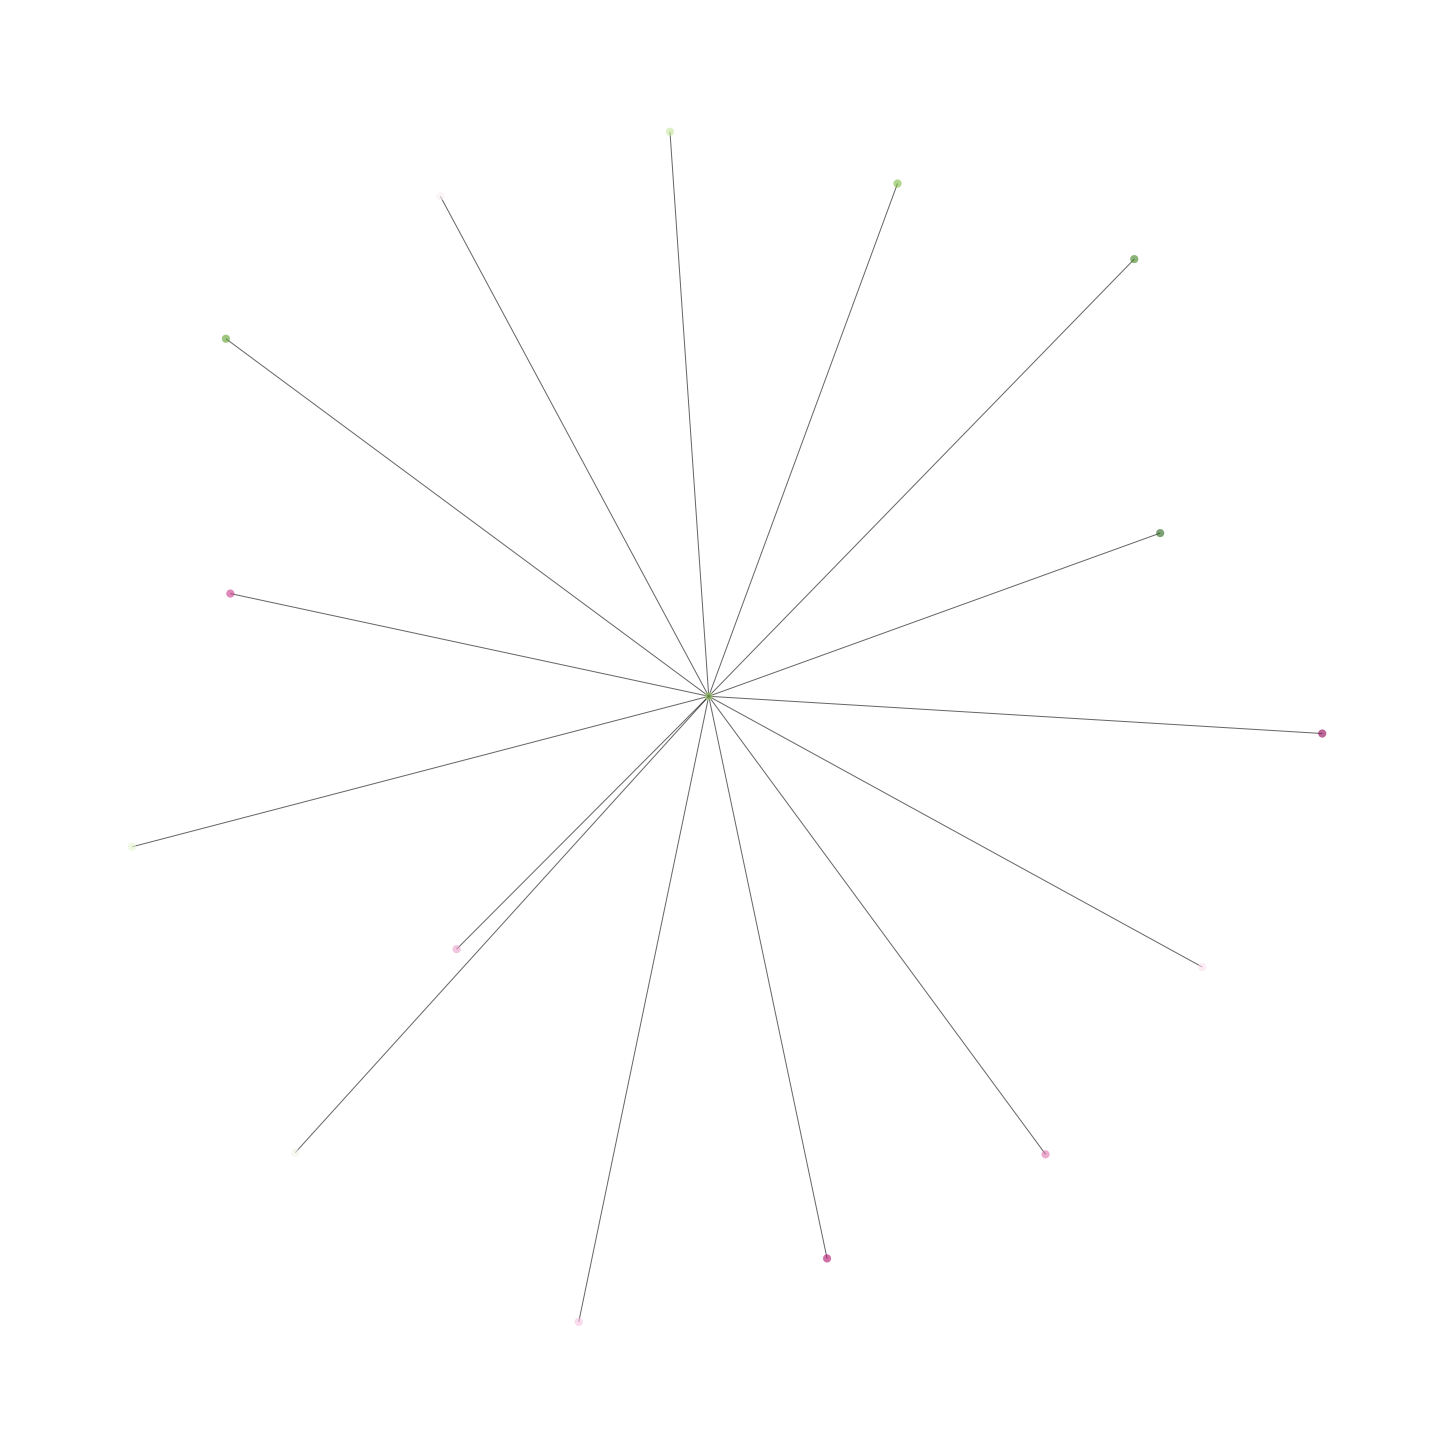

In [38]:
# plot graph
node_and_degree = largest_subgraph.degree()
colors_central_nodes = ['orange', 'red']
central_nodes = '1018650880793444354'
pos = nx.spring_layout(largest_subgraph, k=0.05)
plt.figure(figsize = (20,20))
nx.draw(largest_subgraph, pos=pos, node_color=range(16), cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=300, node_color=colors_central_nodes)
plt.savefig('graphfinal.png')
plt.show()